<a href="https://colab.research.google.com/github/sejin-sim/Anomaly_Detection/blob/main/%5BLecture%5D_Fast_Wearable_Sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1. 데이터 설명

- 4개 Class로 구성된 보행 image data

       ㄴ 선행 작업 : 5개의 IMU 센서 및 FSR arryed-insole를 통해 수집 & 전처리 & sliding window mothod 진행 완료 된 이미지
- Classes : 1(heel off & toe off), 2(Full contact), 3(Heel strike), 4(Swing)
- Training data set image : 13,635개 (1 : 3,236 / 2 : 2,214 / 3 : 2,440 / 4 : 5,745 )

### 2. 조건
- Data resampling : 22 x 14 px → 28 x 28 px
- Data augmentation : Noise 추가
- Model : 3-Layer 제한

### 3. 평가 방법
- Test set 별도 제공 x → 교수님이 별도로 측정
- 제출된 모델의 Test 정밀도 기준 절대구간 평가 예정


In [ ]:
import torch
import torchvision
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init
import PIL

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)

if device =='cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# 압축파일을 colab 가상 폴더에 압축풀기
! mkdir Dataset
! unzip /content/drive/MyDrive/인공지능/trainingset.zip -d /content/Dataset

from IPython.display import clear_output 
clear_output()

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

<Original>


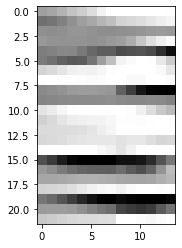

<Resize>


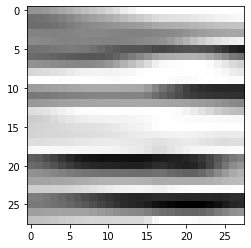

<Resize+Noise>


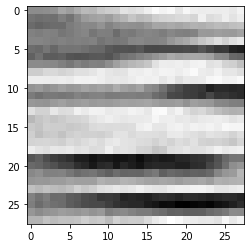

In [ ]:
# Data resampling & augmentation 검토

img = PIL.Image.open("/content/Dataset/2/100.jpg")

# 원본
plt.imshow(img, cmap="gray")
print("<Original>")
plt.show()

# Resize 
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((28, 28)),
                                transforms.Normalize((0.5, ), (0.5, ))
                                ])
img_S = transform(img)
img_S = np.squeeze(np.transpose(img_S, (1, 2,0)), axis=2)
plt.imshow(img_S.numpy(), cmap="gray")
print("<Resize>")
plt.show()


# Resize + Noise
transform_Noise = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Resize((28, 28)),
                                      AddGaussianNoise(0.1, 0.02),
                                      transforms.Normalize((0.5, ), (0.5, ))
                                      ])
img_N = transform_Noise(img)
img_N = np.squeeze(np.transpose(img_N, (1, 2,0)), axis=2)
plt.imshow(img_N.numpy(), cmap="gray")
print("<Resize+Noise>")
plt.show()

In [ ]:
# image dataset upload
transform_train = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.Resize((28, 28)),
                                      AddGaussianNoise(0.1, 0.02),
                                      transforms.Normalize((0.5,), (0.5, ))
                                      ])

image_dataset = dsets.ImageFolder(root="/content/Dataset",
                              transform = transform_train)

classes = image_dataset.classes
print("분류 CLASS :{}".format(classes))

분류 CLASS :['1', '2', '3', '4']


In [ ]:
# train & validation split (7:3)
train_size = int(0.7 * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, test_size])

learning_rate = 0.001
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [ ]:
# MODEL 정의
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(0.4))

        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3))

        self.fc2 = torch.nn.Linear(625, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# CNN 모델 정의
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 38


In [ ]:
def train_model(model, batch_size, patience, n_epochs):

    # 모델이 학습되는 동안 trainning loss를 track
    train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    valid_losses = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []

    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()    
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data , target in test_loader :
            data, target = data.to(device), target.to(device)
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print 학습/검증 statistics
        # epoch당 평균 loss 계산
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))


        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

   # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
n_epochs = 250

# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 30

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs) 

[  1/250] train_loss: 0.67016 valid_loss: 0.49256
Validation loss decreased (inf --> 0.492562).  Saving model ...
[  2/250] train_loss: 0.40955 valid_loss: 0.35177
Validation loss decreased (0.492562 --> 0.351769).  Saving model ...
[  3/250] train_loss: 0.36257 valid_loss: 0.32901
Validation loss decreased (0.351769 --> 0.329011).  Saving model ...
[  4/250] train_loss: 0.32488 valid_loss: 0.33850
EarlyStopping counter: 1 out of 30
[  5/250] train_loss: 0.31385 valid_loss: 0.29474
Validation loss decreased (0.329011 --> 0.294745).  Saving model ...
[  6/250] train_loss: 0.29843 valid_loss: 0.28925
Validation loss decreased (0.294745 --> 0.289251).  Saving model ...
[  7/250] train_loss: 0.28890 valid_loss: 0.26105
Validation loss decreased (0.289251 --> 0.261052).  Saving model ...
[  8/250] train_loss: 0.26894 valid_loss: 0.25232
Validation loss decreased (0.261052 --> 0.252321).  Saving model ...
[  9/250] train_loss: 0.27274 valid_loss: 0.24821
Validation loss decreased (0.252321 -

In [ ]:
# ACC 계산
with torch.no_grad():
  acc = []
  for X, Y in test_loader:
    X = X.to(device)
    Y = Y.to(device)

    prediction = model(X)
    correct_prediction = torch.argmax(prediction, 1) == Y
    accuracy = correct_prediction.float().mean()
    accuracy = accuracy.to("cpu")
    acc.append(accuracy.numpy())
print("평균: {:.2f}%".format(np.mean(acc)*100))

평균: 96.38%


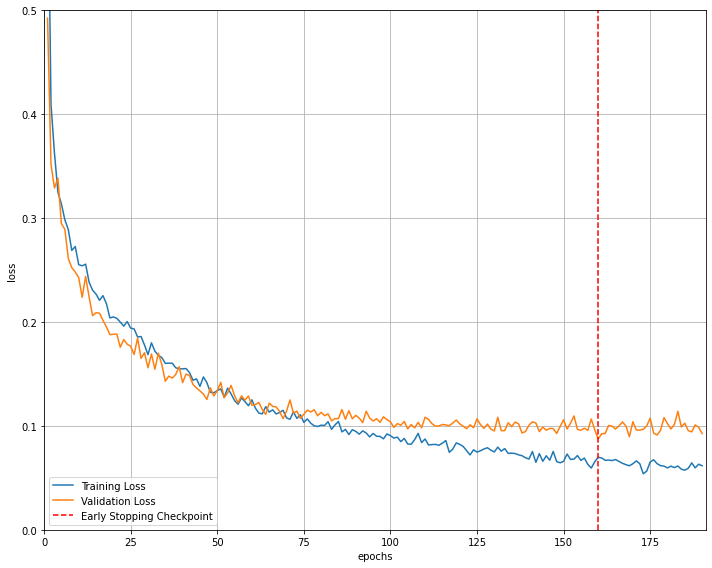

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss, label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5)
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 전체 모델 저장
torch.save(model, "/content/drive/MyDrive/CNN_model_심세진.pt")

### 제출 결과 : 3위 (총 27명)
- Accuracy : 52.32%

- 느낀점
1. MNIST와 같은 훈련 데이터가 아닌 제공된 이미지로 END TO END 작업을 한 건 처음이었는데, Pytorch와 augmentation에 대한 이해가 생긴 것 같다.
2. 데이터 특성 상 Argumentation이 좀 제한적이었지만, 타 데이터 셋을 통해 augmentation에 방법을 더 배우면 좋을 것 같다. 